
#**Contrast Limited Adaptive Histogram Equalization for Detecting Faults in Photovoltaic Cells**


#### O projeto está dividido nas seguintes etapas:

- **Pré-Processamento**:
  - Implementação da técnica CLAHE para melhoria do contraste das imagens EL de células FVs
  - Implementação da técnica LBP para extração de atributos das imagens

- **Implementação da Rede Neural Convolucional**
  - Camadas de convolução, pooling, dropout, etc..

- <s>**Aplicação de _Principal Component Analysis_ (PCA) para redução do conjunto de atributos**</s>

- **Análise dos Resultados obtidos**

## **Importação das Bibliotecas necessárias para o projeto**

As células a seguir são responsáveis por receber as bibliotecas necessárias para a implementação do projeto.

### **Bibliotecas necessárias para a abertura da base de dados e ligação do Google Drive com o Colab**

In [1]:
import glob
from skimage import io
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### **Bibliotecas necessárias para a manipulação de dados, vetores, strings, plotagem de imagens, etc.**

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

### **Bibliotecas necessárias para a normalização em 8-btis e implementação da técnica CLAHE**

In [3]:
import cv2
from skimage.color import rgb2gray
from PIL import Image
import albumentations as A
import os

### **Bibliotecas necessárias para a implementação da Rede Neural Convolucional (``Convolutional Neural Network``)**

In [4]:
#Bibliotecas para usar métodos, funções e classes para a CNN

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Reshape
from tensorflow.keras.layers import BatchNormalization

#Visualização das métricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

tf.__version__

'2.15.0'

## **Seção 0 - Acesso à Base de Dados**

Acessando as imagens e copiando para um diretório temporário no GDrive.

In [5]:
# Cria o diretório para salvar as imagens copiadas da base de dados original
output_dir = '/content/dataset/_imgs_dataset/'
os.makedirs(output_dir, exist_ok = True)

In [6]:
# Cria o diretório para salvar as imagens em CLAHE, se não exisir
output_dir = '/content/dataset/CLAHE/'
os.makedirs(output_dir, exist_ok = True)

In [7]:
# Cria o diretório para armazenar as imagens CLAHE em níveis de cinza
output_dir = '/content/dataset/CLAHE_GRAY'
os.makedirs(output_dir, exist_ok = True)

In [8]:
# Realiza a cópia da pasta com as imagens para o ambiente colab chamado dataset
!cp -r /content/gdrive/MyDrive/__ppgeec_mestrado/_dissertação/_base_de_dados/data_base_augmentation /content/dataset/_imgs_dataset

print('Operação finalizada')

Operação finalizada


In [10]:
# Realiza a cópia do arquivo .csv para a pasta dataset
!cp -r /content/gdrive/MyDrive/__ppgeec_mestrado/_dissertação/_base_de_dados/data_base_augmentation_labels.csv /content/dataset/_imgs_dataset

print('Operação finalizada')

Operação finalizada


In [11]:
# Carregar os dados do arquivo .csv usando o Pandas
labels = pd.read_csv("/content/dataset/_imgs_dataset/data_base_augmentation_labels.csv", sep=';')

In [13]:
# Excluir a coluna 'Unnamed: 3'
labels = labels.drop('Unnamed: 3', axis=1)

In [14]:
# Substituir "1,0" por 1 e "0,0" por 0 na coluna 'prob_defect'
labels['prob_defect'] = labels['prob_defect'].replace({"1,0 ": 1, "0,0 ": 0})

In [15]:
labels

,image,prob_defect,type_cell
0,0001.png,1,mono
1,0002.png,1,mono
2,0003.png,1,mono
3,0004.png,0,mono
4,0005.png,1,mono
...,...,...,...
10491,10492.png,1,poly
10492,10493.png,0,poly
10493,10494.png,0,poly
10494,10495.png,0,poly


## **Seção 1 - CLAHE**

Implementando a técnica CLAHE para melhorar o contraste em imagens, especialmente aquelas que possuem variações significativas de iluminação em diferentes partes da imagem.


In [21]:
# Recebe o caminho das imagens do dataset
images_dir = '/content/dataset/_imgs_dataset/data_monocristalino'

# Criar um objeto de transformação usando a biblioteca Albumentations para
# aplicação do método CLAHE
transform = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True, p=1.0)
    ])

# Loop através do DataFrame para aplicar o aumento de dados a cada imagem
for index, row in labels.iterrows():
    image_name = row['image']
    image_class = row['prob_defect']
    image_type_cells = row['type_cell']

    # Carregar a imagem usando o OpenCV
    image_path = os.path.join(images_dir, image_name)
    img = cv2.imread(image_path)

    if img is None:
        continue  # Ignorar imagens que não foram carregadas corretamente

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converter de BGR para RGB
    img = img.astype(np.uint8)  # Certificar-se de que o tipo seja uint8

    # Aplicar as transformações de data augmentation
    augmented_image = transform(image=img)['image']

    # Salvar a nova imagem aumentada no direteório CLAHE
    augmented_image_name = image_name  # Manter o mesmo nome da imagem original
    augmented_image_path = os.path.join("/content/dataset/CLAHE", augmented_image_name)
    cv2.imwrite(augmented_image_path, augmented_image)

    # Atualizar o arquivo .csv com o nome da nova imagem aumentada e sua classe
    new_row = {'image': augmented_image_name, 'prob_defect': image_class, 'type_cell': image_type_cells}
    labels = labels.append(new_row, ignore_index=True)

# Salvar o DataFrame atualizado em um novo arquivo .csv
#labels.to_csv("/content/dataset/CLAHE/labels_clahe.csv", index=False)  # Caminho das imagens e labels após a aplicação do CLAHE.

print('Operação finalizada!!!')


In [18]:
# Diretório que contém as imagens
diretorio = "/content/dataset/CLAHE"

# Lista todos os arquivos no diretório
arquivos = os.listdir(diretorio)

# Inicializa uma variável para contar o número de imagens
num_imagens = 0

# Verifica cada arquivo no diretório
for arquivo in arquivos:
    # Verifica se o arquivo tem uma extensão de imagem (por exemplo, .jpg, .png, .jpeg, etc.)
    if arquivo.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
        num_imagens += 1

# Imprime o número de imagens encontradas na pasta
print(f"O número de imagens na pasta {diretorio} é: {num_imagens}")


O número de imagens na pasta /content/dataset/CLAHE é: 0


In [ ]:
import os
import cv2

# Diretório que contém as imagens
diretorio = "/content/dataset/CLAHE"

# Lista todos os arquivos no diretório
arquivos = os.listdir(diretorio)

# Inicializa um dicionário para contar o número de imagens por número de canais
num_canais = {}

# Verifica cada arquivo no diretório
for arquivo in arquivos:
    # Constrói o caminho completo do arquivo
    caminho_arquivo = os.path.join(diretorio, arquivo)

    # Verifica se o arquivo tem uma extensão de imagem (por exemplo, .jpg, .jpeg, .png, .gif, .bmp)
    if arquivo.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
        # Lê a imagem usando o OpenCV
        imagem = cv2.imread(caminho_arquivo)

        # Verifica o número de canais na imagem
        num_canal = imagem.shape[-1] if len(imagem.shape) == 3 else 1

        # Atualiza o contador para o número de canais
        if num_canal not in num_canais:
            num_canais[num_canal] = 1
        else:
            num_canais[num_canal] += 1

# Imprime o número de imagens para cada número de canais
for num_canal, num_imagens in num_canais.items():
    print(f"Número de imagens com {num_canal} canal(es): {num_imagens}")


Número de imagens com 3 canal(es): 6636


### **Seção 1.1 - Transformando as imagens resultantes em CLAHE de três canais p/ níveis de cinza**

In [ ]:
import os
import cv2

# Diretório de entrada (imagens coloridas)
diretorio_entrada = "/content/dataset/CLAHE"

# Diretório de saída (imagens em níveis de cinza)
diretorio_saida = "/content/dataset/CLAHE_GRAY"

# Lista todos os arquivos no diretório de entrada
arquivos = os.listdir(diretorio_entrada)

# Itera sobre os arquivos e processa cada imagem
for arquivo in arquivos:
    # Verifica se o arquivo tem uma extensão de imagem (por exemplo, .jpg, .jpeg, .png, .gif, .bmp)
    if arquivo.lower().endswith(('.png')):
        # Caminho completo do arquivo de entrada
        caminho_entrada = os.path.join(diretorio_entrada, arquivo)

        # Carrega a imagem colorida
        imagem_colorida = cv2.imread(caminho_entrada)

        # Converte a imagem para níveis de cinza
        imagem_em_cinza = cv2.cvtColor(imagem_colorida, cv2.COLOR_RGB2GRAY)

        # Caminho completo do arquivo de saída
        caminho_saida = os.path.join(diretorio_saida, arquivo)

        # Salva a imagem em níveis de cinza no diretório de saída com o mesmo nome
        cv2.imwrite(caminho_saida, imagem_em_cinza)

print("Conversão concluída. As imagens em níveis de cinza foram salvas em:", diretorio_saida)


Conversão concluída. As imagens em níveis de cinza foram salvas em: /content/dataset/CLAHE_GRAY


In [ ]:
# Diretório que contém as imagens
diretorio = "/content/dataset/CLAHE_GRAY"

# Lista todos os arquivos no diretório
arquivos = os.listdir(diretorio)

# Inicializa uma variável para contar o número de imagens
num_imagens = 0

# Verifica cada arquivo no diretório
for arquivo in arquivos:
    # Verifica se o arquivo tem uma extensão de imagem (por exemplo, .jpg, .png, .jpeg, etc.)
    if arquivo.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
        num_imagens += 1

# Imprime o número de imagens encontradas na pasta
print(f"O número de imagens na pasta {diretorio} é: {num_imagens}")

O número de imagens na pasta /content/dataset/CLAHE_GRAY é: 6636


### **Seção 1.2 - Redimensionando as imagens para o tamanho 224x224**

In [16]:

# Diretório onde as imagens originais estão localizadas
diretorio_originais = "/content/dataset/_imgs_dataset/data_base_augmentation"

# Diretório onde você deseja salvar as imagens redimensionadas
diretorio_redimensionadas = "/content/dataset/CLAHE_REDIMENSIONED"

# Certifique-se de que o diretório de saída existe
if not os.path.exists(diretorio_redimensionadas):
    os.makedirs(diretorio_redimensionadas)

# Tamanho de destino para redimensionamento (224x224 pixels para VGG16)
target_size = (224, 224)

# Lista todos os arquivos no diretório de originais
arquivos = os.listdir(diretorio_originais)

# Itera sobre os arquivos e redimensiona cada imagem
for arquivo in arquivos:
    # Verifica se o arquivo tem uma extensão de imagem (por exemplo, .jpg, .jpeg, .png, .gif, .bmp)
    if arquivo.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
        # Caminho completo do arquivo de entrada (original)
        caminho_originais = os.path.join(diretorio_originais, arquivo)

        # Carrega a imagem original
        imagem_original = cv2.imread(caminho_originais)

        # Redimensiona a imagem para o tamanho de destino
        imagem_redimensionada = cv2.resize(imagem_original, target_size)

        # Caminho completo do arquivo de saída (redimensionado)
        caminho_redimensionadas = os.path.join(diretorio_redimensionadas, arquivo)

        # Salva a imagem redimensionada no diretório de saída
        cv2.imwrite(caminho_redimensionadas, imagem_redimensionada)

print("Redimensionamento concluído. As imagens foram salvas em:", diretorio_redimensionadas)


Redimensionamento concluído. As imagens foram salvas em: /content/dataset/CLAHE_REDIMENSIONED


In [17]:
# Diretório que contém as imagens
diretorio = "/content/dataset/CLAHE_REDIMENSIONED"

# Lista todos os arquivos no diretório
arquivos = os.listdir(diretorio)

# Inicializa uma variável para contar o número de imagens
num_imagens = 0

# Verifica cada arquivo no diretório
for arquivo in arquivos:
    # Verifica se o arquivo tem uma extensão de imagem (por exemplo, .jpg, .png, .jpeg, etc.)
    if arquivo.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
        num_imagens += 1

# Imprime o número de imagens encontradas na pasta
print(f"O número de imagens na pasta {diretorio} é: {num_imagens}")

O número de imagens na pasta /content/dataset/CLAHE_REDIMENSIONED é: 10496


## **Seção 3 - Resultados do Pré-Processamento**

Apresentando os resultados do pré-processamento

In [ ]:
L_grid = 1 # Define o número de linhas
W_grid = 5 # Define o número de imagens por linha

# Seleciona cinco índices aleatórios para as imagens
random_indices = np.random.choice(len(imgs_gray), 5, replace=False)

# Cria a figura e os eixos para as imagens originais
fig, axes = plt.subplots(L_grid, W_grid, figsize=(10, 5))
axes = axes.ravel()

# Título para o conjunto de imagens originais
fig.suptitle("Imagens Originais", fontsize=15)

# Plota os resultados das técnicas para as cinco imagens aleatórias
for i in range(W_grid):
    img_name = labels.loc[random_indices[i], 'image']
    img_path = os.path.join("/content/dataset/imgs_augmentation", img_name)
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(img_gray, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(img_name)

# Cria a figura e os eixos para as imagens CLAHE
fig, axes = plt.subplots(L_grid, W_grid, figsize=(10, 5))
axes = axes.ravel()

# Título para o conjunto de imagens CLAHE
fig.suptitle("Resultados da aplicação CLAHE", fontsize=15)

# Plota os resultados das técnicas para as cinco imagens aleatórias
for i in range(W_grid):
    img_name = labels.loc[random_indices[i], 'image']
    img_path = os.path.join("/content/dataset/CLAHE", img_name)
    img_clahe = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(img_clahe, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(img_name)


# Ajusta o espaçamento entre os subplots
plt.subplots_adjust(hspace=0.6, top=0.8, bottom=0.0)  # Ajusta o espaçamento e a posição dos títulos

# Exibe o gráfico
plt.show()




NameError: ignored

## **Seção 4 - Convolutional Neural Network**

Implementação da Rede Neural Convolucional

### **Seção 4.0 - Manipulação dos dados**

- Ligando imagens e rótulos
- Análise dos dados
- Normalização
- Divisão do conjunto de treinamento, validação e teste.

In [18]:
# Recebe o caminho das imagens do dataset
images_dir = '/content/dataset/CLAHE_REDIMENSIONED'

# Carregar os dados do arquivo .csv
images_classes = labels

# Adicionar o caminho completo das imagens ao dataframe
images_classes['image_path'] = images_classes['image'].apply(lambda x: os.path.join(images_dir, x))

In [19]:
labels

,image,prob_defect,type_cell,image_path
0,0001.png,1,mono,/content/dataset/CLAHE_REDIMENSIONED/0001.png
1,0002.png,1,mono,/content/dataset/CLAHE_REDIMENSIONED/0002.png
2,0003.png,1,mono,/content/dataset/CLAHE_REDIMENSIONED/0003.png
3,0004.png,0,mono,/content/dataset/CLAHE_REDIMENSIONED/0004.png
4,0005.png,1,mono,/content/dataset/CLAHE_REDIMENSIONED/0005.png
...,...,...,...,...
10491,10492.png,1,poly,/content/dataset/CLAHE_REDIMENSIONED/10492.png
10492,10493.png,0,poly,/content/dataset/CLAHE_REDIMENSIONED/10493.png
10493,10494.png,0,poly,/content/dataset/CLAHE_REDIMENSIONED/10494.png
10494,10495.png,0,poly,/content/dataset/CLAHE_REDIMENSIONED/10495.png


In [20]:
images_classes['image_path']

0         /content/dataset/CLAHE_REDIMENSIONED/0001.png
1         /content/dataset/CLAHE_REDIMENSIONED/0002.png
2         /content/dataset/CLAHE_REDIMENSIONED/0003.png
3         /content/dataset/CLAHE_REDIMENSIONED/0004.png
4         /content/dataset/CLAHE_REDIMENSIONED/0005.png
                              ...                      
10491    /content/dataset/CLAHE_REDIMENSIONED/10492.png
10492    /content/dataset/CLAHE_REDIMENSIONED/10493.png
10493    /content/dataset/CLAHE_REDIMENSIONED/10494.png
10494    /content/dataset/CLAHE_REDIMENSIONED/10495.png
10495    /content/dataset/CLAHE_REDIMENSIONED/10496.png
Name: image_path, Length: 10496, dtype: object

In [21]:
# Contagem de cada tipo de imagem (rótulo)
image_counts = images_classes['prob_defect'].value_counts()

print("Quantidade de cada tipo de imagem:")
print(image_counts)


Quantidade de cada tipo de imagem:
prob_defect
0    5804
1    4692
Name: count, dtype: int64


In [22]:
# Contagem de cara tipo de célula:
type_cell_counts = images_classes['type_cell'].value_counts()
print('Quantidade de tipo de células:')
print(type_cell_counts)

Quantidade de tipo de células:
type_cell
poly    6200
mono    4296
Name: count, dtype: int64


In [23]:
# função para normalização dos dados:
def normalize_image(images_path):
    image = io.imread(images_path)
    normalized_image = image / 255.0  # Normalização para valores entre 0 e 1
    return normalized_image

images_classes['normalized_image'] = images_classes['image_path'].apply(normalize_image)

In [24]:
# Apresenta o dataset com uma nova coluna chamada 'normalized_image'
images_classes

,image,prob_defect,type_cell,image_path,normalized_image
0,0001.png,1,mono,/content/dataset/CLAHE_REDIMENSIONED/0001.png,"[[[0.054901960784313725, 0.054901960784313725,..."
1,0002.png,1,mono,/content/dataset/CLAHE_REDIMENSIONED/0002.png,"[[[0.11372549019607843, 0.11372549019607843, 0..."
2,0003.png,1,mono,/content/dataset/CLAHE_REDIMENSIONED/0003.png,"[[[0.11372549019607843, 0.11372549019607843, 0..."
3,0004.png,0,mono,/content/dataset/CLAHE_REDIMENSIONED/0004.png,"[[[0.13725490196078433, 0.13725490196078433, 0..."
4,0005.png,1,mono,/content/dataset/CLAHE_REDIMENSIONED/0005.png,"[[[0.15294117647058825, 0.15294117647058825, 0..."
...,...,...,...,...,...
10491,10492.png,1,poly,/content/dataset/CLAHE_REDIMENSIONED/10492.png,"[[[0.1568627450980392, 0.1568627450980392, 0.1..."
10492,10493.png,0,poly,/content/dataset/CLAHE_REDIMENSIONED/10493.png,"[[[0.17254901960784313, 0.17254901960784313, 0..."
10493,10494.png,0,poly,/content/dataset/CLAHE_REDIMENSIONED/10494.png,"[[[0.24313725490196078, 0.24313725490196078, 0..."
10494,10495.png,0,poly,/content/dataset/CLAHE_REDIMENSIONED/10495.png,"[[[0.1803921568627451, 0.1803921568627451, 0.1..."


In [25]:
# Dividir os dados em conjunto de treinamento e teste
X = images_classes['normalized_image']  # Features (imagens normalizadas)

# Substituir "1,0" por 1 e "0,0" por 0 na coluna 'prob_defect'
#images_classes['prob_defect'] = images_classes['prob_defect'].replace({"1,0": 1, "0,0": 0})

y = images_classes['prob_defect']  # Rótulos de classe

# Definir a proporção de divisão, por exemplo, 80% para treinamento e 30% para teste
test_size = 0.2

# Use a função train_test_split para realizar a divisão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# X_train: Conjunto de treinamento de features
# X_test: Conjunto de teste de features
# y_train: Conjunto de treinamento de rótulos de classe
# y_test: Conjunto de teste de rótulos de classe

# Converter as matrizes NumPy em listas de Python
X_train_list = X_train.tolist()
y_train_list = y_train.tolist()
X_test_list = X_test.tolist()
y_test_list = y_test.tolist()

from tensorflow.keras.utils import to_categorical

# Suponha que você tenha duas classes (0 e 1)
num_classes = 2

# Codifique seus rótulos
y_train_encoded = to_categorical(y_train_list, num_classes)
y_test_encoded = to_categorical(y_test_list, num_classes)

# Converter as listas em tensores TensorFlow
X_train_tf = tf.convert_to_tensor(X_train_list, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train_list, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test_list, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test_list, dtype=tf.float32)



### **Seção 4.1 - Modelo Proposto**

Implementação da Rede Neural Convolucional

#### **Seção 4.1.1 - Modelo VGG-16 treinado do zero**

In [ ]:
#Filtros das camadas de convolução
c_entrada = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 2048]

#Neurônios das camadas totalmente conectadas
c_dense = [2048, 4090, 2]

#kernel
kernel = (2, 2)

#strides (conv)
strd = 1

#pool size
pool = (2, 2)

#Função de ativação das camadas de convolução
act_func = 'relu'

# Função de ativação do Classificador
act_func_class = 'softmax'

#Inicializadores dos kernels
initializer1 = tf.keras.initializers.RandomUniform(minval=0., maxval=1., seed=40)
initializer2 = tf.keras.initializers.GlorotNormal(seed=38)
initializer3 = tf.keras.initializers.HeNormal(seed=35)
initializer4 = tf.keras.initializers.HeUniform(seed=43)
initializer5 = tf.keras.initializers.Orthogonal(seed=42)
initializer6 = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform', seed=24)

#=========================MODELO============================
model_cnn = models.Sequential()

# 1 e 2 Camada de convolução
model_cnn.add(layers.Conv2D(c_entrada[0], kernel, strd, padding='same', input_shape=(224, 224, 3), activation = act_func, kernel_initializer = initializer1))
model_cnn.add(layers.Conv2D(c_entrada[1], kernel, strd, padding='same',activation = act_func, kernel_initializer = initializer1))
# 1 Camada de pooling
model_cnn.add(layers.MaxPooling2D(pool, padding = 'same'))
model_cnn.add(BatchNormalization())

# 3 e 4 Camada de convolução
model_cnn.add(layers.Conv2D(c_entrada[2], kernel, strd, padding='same', activation = act_func, kernel_initializer = initializer2))
model_cnn.add(layers.Conv2D(c_entrada[3], kernel, strd, padding='same', activation = act_func, kernel_initializer = initializer2))
# 2 Camada de pooling
model_cnn.add(layers.MaxPooling2D(pool, padding = 'same'))
model_cnn.add(BatchNormalization())

# 5, 6 e 7 Camada de convolução
model_cnn.add(layers.Conv2D(c_entrada[4], kernel, strd, padding='same', activation = act_func, kernel_initializer = initializer3))
model_cnn.add(layers.Conv2D(c_entrada[5], kernel, strd, padding='same', activation = act_func, kernel_initializer = initializer3))
model_cnn.add(layers.Conv2D(c_entrada[6], kernel, strd, padding='same', activation = act_func, kernel_initializer = initializer4))
# 3 Camada de pooling
model_cnn.add(layers.MaxPooling2D(pool, padding = 'same'))
model_cnn.add(BatchNormalization())

# 8, 9 e 10 Camada de convolução
model_cnn.add(layers.Conv2D(c_entrada[7], kernel, strd, padding='same', activation = act_func, kernel_initializer = initializer5))
model_cnn.add(layers.Conv2D(c_entrada[8], kernel, strd, padding='same', activation = act_func, kernel_initializer = initializer5))
model_cnn.add(layers.Conv2D(c_entrada[9], kernel, strd, padding='same', activation = act_func, kernel_initializer = initializer5))
# 4 Camada de pooling
model_cnn.add(layers.MaxPooling2D(pool, padding = 'same'))
model_cnn.add(BatchNormalization())

# 11, 12 e 13 Camada de convolução
model_cnn.add(layers.Conv2D(c_entrada[10], kernel, strd, padding='same', activation = act_func, kernel_initializer = initializer6))
model_cnn.add(layers.Conv2D(c_entrada[11], kernel, strd, padding='same', activation = act_func, kernel_initializer = initializer6))
model_cnn.add(layers.Conv2D(c_entrada[12], kernel, strd, padding='same', activation = act_func, kernel_initializer = initializer6))
# 5 Camada de pooling
model_cnn.add(layers.MaxPooling2D(pool, padding = 'same'))
model_cnn.add(BatchNormalization())

# Conversão da matriz de atributos para vetor
model_cnn.add(layers.Flatten())

# 1 Camada totalmente conectada
model_cnn.add(layers.Dense(c_dense[0], activation = act_func))
model_cnn.add(Dropout(0.3))

# 2 Camada totalmente conectada
model_cnn.add(layers.Dense(c_dense[1], activation = act_func))
model_cnn.add(Dropout(0.3))

# Última camada do classificador com a função de ativação softmax
model_cnn.add(layers.Dense(c_dense[2], activation = act_func_class))

In [ ]:
model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_321 (Conv2D)         (None, 224, 224, 64)      832       
                                                                 
 conv2d_322 (Conv2D)         (None, 224, 224, 64)      16448     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_297 (B  (None, 112, 112, 64)      256       
 atchNormalization)                                              
                                                                 
 conv2d_323 (Conv2D)         (None, 112, 112, 128)     32896     
                                                                 
 conv2d_324 (Conv2D)         (None, 112, 112, 128)    

#### **Seção 4.1.2 - Modelo VGG-16 Pré-treinado com ImageNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Diretório onde as imagens estão localizadas
diretorio_imagens = '/content/dataset/CLAHE_REDIMENSIONED'

# Diretório onde você deseja salvar o modelo treinado
diretorio_saida_modelo = '/content/gdrive/MyDrive/_code_dissertacao/best_model'

# Certifique-se de que o diretório de saída existe
if not os.path.exists(diretorio_saida_modelo):
    os.makedirs(diretorio_saida_modelo)

# Tamanho da imagem que você deseja usar como entrada do modelo VGG16
input_shape = (224, 224, 3)  # 3 canais de cores para o VGG16

# Carregar o modelo VGG16 pré-treinado com pesos da ImageNet (include_top=False para não incluir a camada de classificação)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar todas as camadas do modelo VGG16 para que não sejam treinadas novamente
for layer in base_model.layers:
    layer.trainable = False

# Criar um modelo sequencial para adicionar camadas personalizadas
model_cnn = tf.keras.Sequential()

# Adicionar o modelo VGG16 como uma camada
model_cnn.add(base_model)

# Adicionar camadas personalizadas após o VGG16
model_cnn.add(Flatten())
model_cnn.add(Dense(1024, activation='relu'))
#model_cnn.add(Dropout(0.2))  # Primeira camada totalmente conectada
model_cnn.add(Dense(4096, activation='relu'))
model_cnn.add(Dropout(0.2))  # Segunda camada totalmente conectada
model_cnn.add(Dense(4096, activation='relu'))
model_cnn.add(Dropout(0.2))  # Terceira camada totalmente conectada
model_cnn.add(Dense(2, activation='softmax'))  # Camada de saída com 2 classes (ajuste de acordo com o seu problema)


58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 4096)              4198400   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0

#### **Seção 4.1.3 - Modelo ResNet50 Pré-treinado com ImageNet**

In [32]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Diretório onde as imagens estão localizadas
diretorio_imagens = '/content/dataset/CLAHE_REDIMENSIONED'

# Diretório onde você deseja salvar o modelo treinado
diretorio_saida_modelo = '/content/gdrive/MyDrive/_code_dissertacao/best_model'

# Certifique-se de que o diretório de saída existe
if not os.path.exists(diretorio_saida_modelo):
    os.makedirs(diretorio_saida_modelo)

# Tamanho da imagem que você deseja usar como entrada do modelo ResNet50
input_shape = (224, 224, 3)  # 3 canais de cores para o ResNet50

# Carregar o modelo ResNet50 pré-treinado com pesos da ImageNet (include_top=False para não incluir a camada de classificação)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar todas as camadas do modelo ResNet50 para que não sejam treinadas novamente
for layer in base_model.layers:
    layer.trainable = False

# Criar um modelo sequencial para adicionar camadas personalizadas
model_cnn = tf.keras.Sequential()

# Adicionar o modelo ResNet50 como uma camada
model_cnn.add(base_model)

# Adicionar camadas personalizadas após o ResNet50
model_cnn.add(Flatten())
model_cnn.add(Dense(2048, activation='relu'))
#model_cnn.add(Dropout(0.3))  # Primeira camada totalmente conectada
model_cnn.add(Dense(2048, activation='relu'))
model_cnn.add(Dropout(0.3))  # Segunda camada totalmente conectada
model_cnn.add(Dense(2, activation='softmax'))  # Camada de saída com 2 classes (ajuste de acordo com o seu problema)


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_16 (Dense)            (None, 2048)              205522944 
                                                                 
 dense_17 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 233311106 (890.01 MB)
Trainable params: 

#### **Seção 4.1.4 Modelo InceptionV3 Pré-treinado com ImageNet**

In [26]:
import os
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Diretório onde as imagens estão localizadas
diretorio_imagens = '/content/dataset/CLAHE'

# Diretório onde você deseja salvar o modelo treinado
diretorio_saida_modelo = '/content/gdrive/MyDrive/_code_dissertacao/best_model'

# Certifique-se de que o diretório de saída existe
if not os.path.exists(diretorio_saida_modelo):
    os.makedirs(diretorio_saida_modelo)

# Tamanho da imagem que você deseja usar como entrada do modelo InceptionV3
input_shape = (224, 224, 3)  # 3 canais de cores para o InceptionV3

# Carregar o modelo InceptionV3 pré-treinado com pesos da ImageNet (include_top=False para não incluir a camada de classificação)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar todas as camadas do modelo InceptionV3 para que não sejam treinadas novamente
for layer in base_model.layers:
    layer.trainable = False

# Criar um modelo sequencial para adicionar camadas personalizadas
model_cnn = tf.keras.Sequential()

# Adicionar o modelo InceptionV3 como uma camada
model_cnn.add(base_model)

# Adicionar camadas personalizadas após o InceptionV3
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
#model_cnn.add(Dropout(0.5))  # Primeira camada totalmente conectada
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dropout(0.5))  # Segunda camada totalmente conectada
model_cnn.add(Dense(2, activation='softmax'))  # Camada de saída com 2 classes (ajuste de acordo com o seu problema)


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 51200)             0         
                                                                 
 dense_13 (Dense)            (None, 128)               6553728   
                                                                 
 dense_14 (Dense)            (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 2)                 514       
                                                                 
Total params: 28390050 (108.30 MB)
Trainable params: 6

### **Seção 4.2 - Treinamento e Teste do Modelo**

Realizando o trainamento e Teste do modelo

In [27]:
# Compilar o modelo
model_cnn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Treinar o modelo
batch_size = 90  # Tamanho do lote
epochs = 130  # Número de épocas

history = model_cnn.fit(X_train_tf, y_train_encoded,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=2)

Epoch 1/130
75/75 - 30s - loss: 0.8543 - accuracy: 0.6702 - val_loss: 0.5374 - val_accuracy: 0.7244 - 30s/epoch - 399ms/step
Epoch 2/130
75/75 - 8s - loss: 0.5242 - accuracy: 0.7327 - val_loss: 0.4947 - val_accuracy: 0.7476 - 8s/epoch - 100ms/step
Epoch 3/130
75/75 - 7s - loss: 0.4840 - accuracy: 0.7616 - val_loss: 0.5103 - val_accuracy: 0.7125 - 7s/epoch - 100ms/step
Epoch 4/130
75/75 - 7s - loss: 0.4488 - accuracy: 0.7762 - val_loss: 0.4877 - val_accuracy: 0.7595 - 7s/epoch - 100ms/step
Epoch 5/130
75/75 - 7s - loss: 0.4213 - accuracy: 0.7926 - val_loss: 0.4561 - val_accuracy: 0.7774 - 7s/epoch - 99ms/step
Epoch 6/130
75/75 - 7s - loss: 0.4029 - accuracy: 0.8091 - val_loss: 0.4966 - val_accuracy: 0.7851 - 7s/epoch - 100ms/step
Epoch 7/130
75/75 - 7s - loss: 0.3712 - accuracy: 0.8276 - val_loss: 0.4755 - val_accuracy: 0.7815 - 7s/epoch - 99ms/step
Epoch 8/130
75/75 - 7s - loss: 0.3702 - accuracy: 0.8484 - val_loss: 0.4517 - val_accuracy: 0.7899 - 7s/epoch - 100ms/step
Epoch 9/130
75/7

### **Seção 4.3 - Análise da Performance do Modelo**

Verificando a acurácia no conjunto de treinamento.

#### **Seção 4.3.1 - Análise da Performance do Modelo VGG-16**

In [ ]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model_cnn.evaluate(X_test_tf, y_test_encoded, verbose=1)

print(f'Acurácia no conjunto de teste do modelo VGG-16 pré-treinado com ImageNet: {test_accuracy}')

42/42 [==============================] - 2s 36ms/step - loss: 0.8390 - accuracy: 0.9375
Acurácia no conjunto de teste do modelo VGG-16 pré-treinado com ImageNet: 0.9375


#### **Seção 4.3.1 - Análise da Performance do Modelo ResNet50**

In [35]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model_cnn.evaluate(X_test_tf, y_test_encoded, verbose=1)

print(f'Acurácia no conjunto de teste do modelo ResNet50 pré-treinado com ImageNet: {test_accuracy}')

5/5 [==============================] - 2s 189ms/step - loss: 0.4634 - accuracy: 0.8162
Acurácia no conjunto de teste do modelo ResNet50 pré-treinado com ImageNet: 0.8161764740943909


#### **Seção 4.3.1 - Análise da Performance do Modelo InceptionV3**

In [29]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model_cnn.evaluate(X_test_tf, y_test_encoded, verbose=1)

print(f'Acurácia no conjunto de teste do modelo InceptionV3 pré-treinado com ImageNet: {test_accuracy}')

66/66 [==============================] - 6s 57ms/step - loss: 1.1752 - accuracy: 0.8205
Acurácia no conjunto de teste do modelo InceptionV3 pré-treinado com ImageNet: 0.8204761743545532


#### **Seção 4.3.1 - Análise da Performance do Modelo cnn_modell**

In [ ]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model_cnn.evaluate(X_test_tf, y_test_encoded, verbose=1)

print(f'Acurácia no conjunto de teste do modelo cnn_model Treinado do zero: {test_accuracy}')

42/42 [==============================] - 1s 25ms/step - loss: 0.2808 - accuracy: 0.9420
Acurácia no conjunto de teste do modelo cnn_model Treinado do zero: 0.9420180916786194


### **Seção 4.3.4 - Salvando os modelos**

In [ ]:
#salvar o modelo
model_cnn.save('/content/gdrive/MyDrive/_code_dissertacao/best_model/vgg16_clahe.h5')
print('Modelo salvo com sucesso!!')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modelo salvo com sucesso!!


In [ ]:
#salvar o modelo
model_cnn.save('/content/gdrive/MyDrive/_code_dissertacao/best_model/resnet50_clahe.h5')
print('Modelo salvo com sucesso!!')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modelo salvo com sucesso!!


In [ ]:
#salvar o modelo
model_cnn.save('/content/gdrive/MyDrive/_code_dissertacao/best_model/inceptionv3_clahe.h5')
print('Modelo salvo com sucesso!!')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modelo salvo com sucesso!!


In [ ]:
model_cnn.save('/content/gdrive/MyDrive/_code_dissertacao_best_model/cnn_model.h5')
print('Modelo salvo com sucesso!!')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modelo salvo com sucesso!!


### **Seção 4.4 - Análise Qualitativa dos Resultados**

Apresentando algumas imagens e suas respectivas classificações realizadas pelo modelo proposto

66/66 [==============================] - 2s 28ms/step


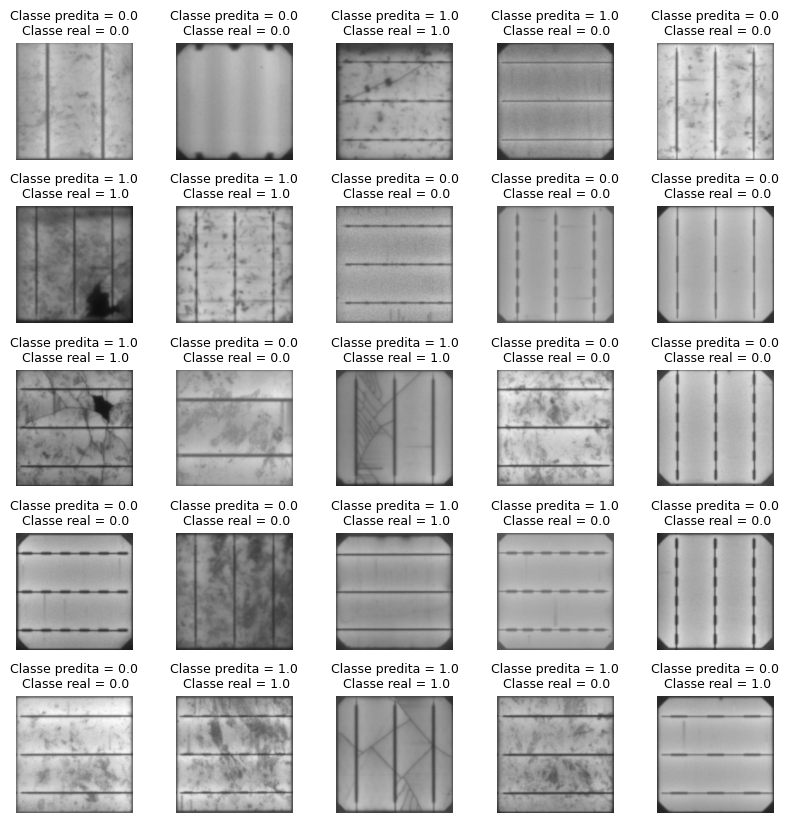

In [32]:
# Exemplos de predições corretas e incorretas
predict_x = model_cnn.predict(X_test_tf)
predicted_classes = np.argmax(predict_x, axis=1)

W_grid = 5
L_grid = 5
fig, axes = plt.subplots(L_grid, W_grid, figsize=(10, 10))
axes = axes.ravel()

for i in np.arange(0, W_grid * L_grid):
    axes[i].imshow(X_test_list[i])  # Não é necessário redimensionar
    axes[i].set_title("Classe predita = {:0.1f}\n Classe real = {:0.1f}".format(predicted_classes[i], y_test_list[i]), fontsize=9)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)


### **Seção 4.5 - Matriz de Confusão dos Resultados**

Matriz de Confusão

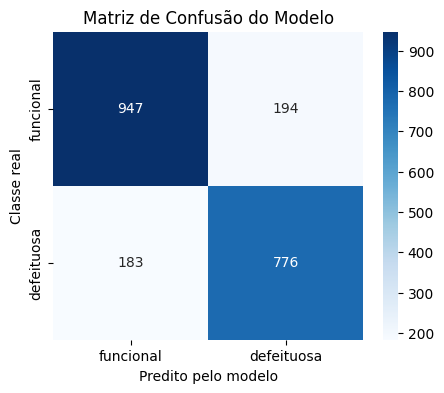

In [31]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test_list, predicted_classes)

# Mapear as classes para rótulos descritivos
classes = ["funcional", "defeituosa"]

# Plotar a matriz de confusão como um heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predito pelo modelo')
plt.ylabel('Classe real')
plt.title('Matriz de Confusão do Modelo')
plt.show()


In [ ]:
cm

array([[648,  20],
       [ 57, 603]])

### **Seção 4.6 - Outras métricas de validação**

Acuárica, _recall_ e F1-Score de cada classe

In [ ]:
from sklearn.metrics import classification_report

# Defina o número correto de classes
num_classes = 2

# Nomes das classes
target_names = ["Class {}".format(i) for i in range(num_classes)]

# Calcule e imprima o relatório de classificação
report = classification_report(y_test_list, predicted_classes, target_names=target_names)
print(report)


              precision    recall  f1-score   support

     Class 0       0.92      0.97      0.94       668
     Class 1       0.97      0.91      0.94       660

    accuracy                           0.94      1328
   macro avg       0.94      0.94      0.94      1328
weighted avg       0.94      0.94      0.94      1328



### **Seção 4.7 - Curva da perda por n° de épocas**

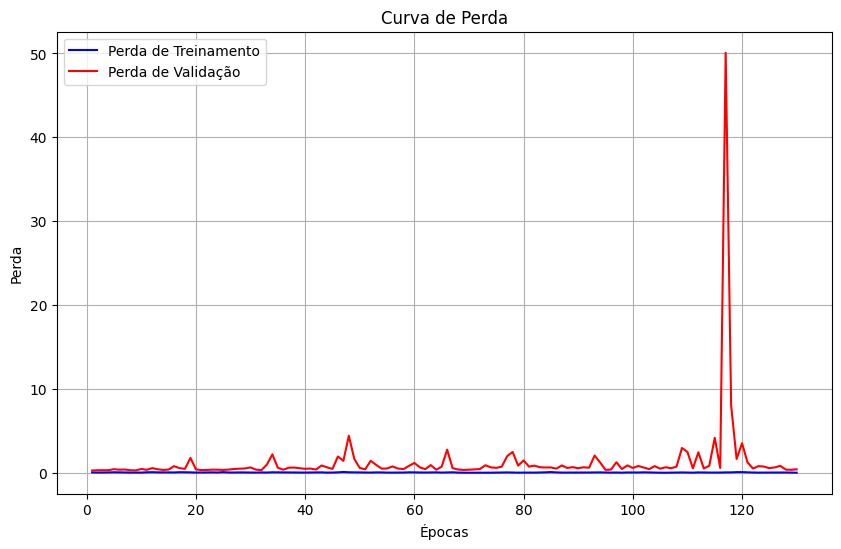

In [ ]:
# Extrair as curvas de perda do histórico
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotar a curva de perda
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Perda de Treinamento')
plt.plot(epochs, val_loss, 'r', label='Perda de Validação')
plt.title('Curva de Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.show()
